<a href="https://colab.research.google.com/github/omatheuscarvalho/Calculadora-de-IMC/blob/main/Bitcoin_Price_Prediction_ARIMA_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00


In [ ]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
import numpy as np

In [ ]:
# Carregando modelo inicial
btc_data = pd.read_csv('BTC-Daily.csv')
btc_data['date'] = pd.to_datetime(btc_data['date'])
btc_data.set_index('date', inplace=True)
btc_series = btc_data[['close']]

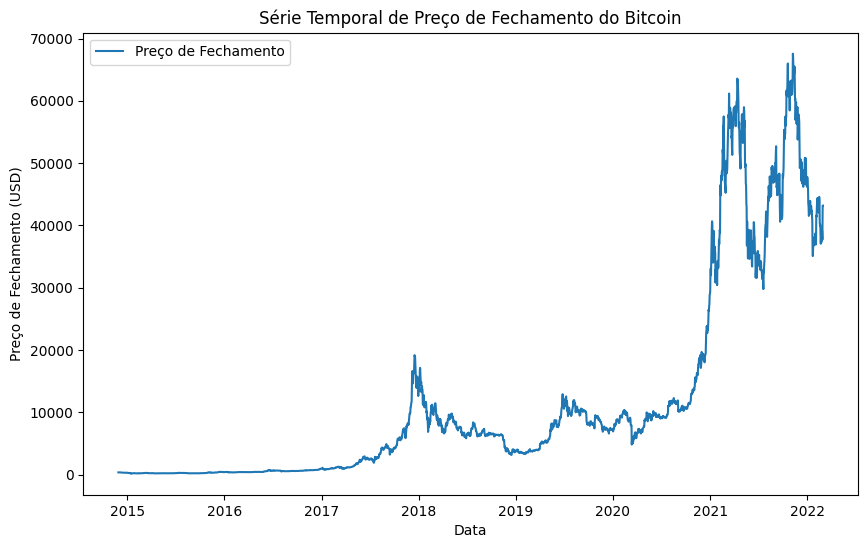

In [ ]:
# Plotando a série original
plt.figure(figsize=(10, 6))
plt.plot(btc_series['close'], label='Preço de Fechamento')
plt.title('Série Temporal de Preço de Fechamento do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.show()

In [ ]:
# Diferenciando a série temporal (remover sazionalidade)
btc_series_diff = btc_series.diff().dropna()

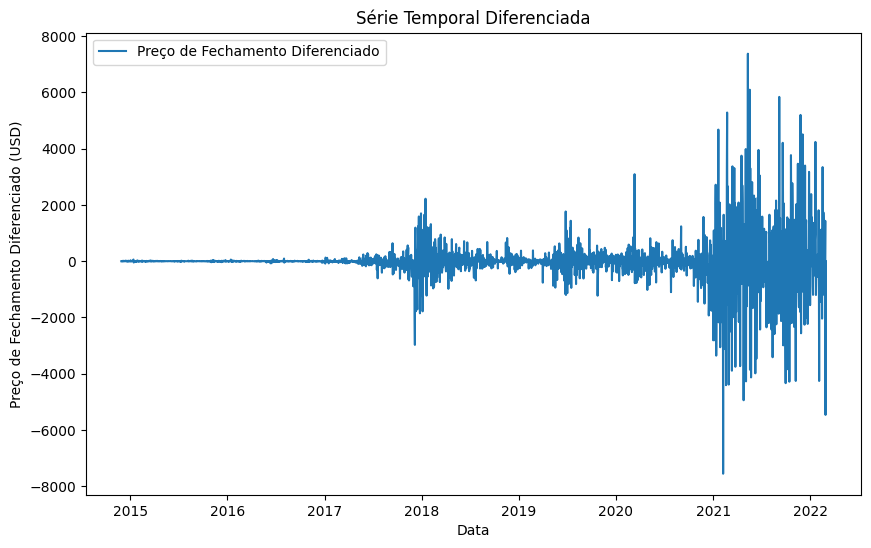

In [ ]:
# Plotando série diferenciada
plt.figure(figsize=(10, 6))
plt.plot(btc_series_diff['close'], label='Preço de Fechamento Diferenciado')
plt.title('Série Temporal Diferenciada')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Diferenciado (USD)')
plt.legend()
plt.show()

In [ ]:
# Teste dickey-fuller
adf_result = adfuller(btc_series_diff['close'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

if adf_result[1] <= 0.05:
    print("A série é estacionária.")
else:
    print("A série não é estacionária.")

ADF Statistic: -8.529483755605046
p-value: 1.0470896570981676e-13
A série é estacionária.


In [ ]:
# Treinando ARIMA
model = pm.auto_arima(btc_series_diff['close'], seasonal=False, trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=5.73 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=42943.289, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=42941.520, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=42941.862, Time=0.15 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=42943.701, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=42943.832, Time=0.22 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=42945.592, Time=0.56 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=42942.351, Time=0.16 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 7.137 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2650
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -21468.760
Date:                Fri, 30 Aug 2024   AIC                          42941.520
Time:                        22:32:13   BIC                          42953.285
Sample:                             0   HQIC                         42945.779
                               - 2650                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0377      0.010     -3.877      0.000      -0.057      -0.019
sigma2      6.375e+05   5479.435    116.347      0.000    6.27e+05    6.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38617.34
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# PREVISÃO
n_periods = 30
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
forecast_index = pd.date_range(start=btc_series_diff.index[-1], periods=n_periods + 1, freq='D')[1:]
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecast'])
forecast_df['Lower Bound'] = conf_int[:, 0]
forecast_df['Upper Bound'] = conf_int[:, 1]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


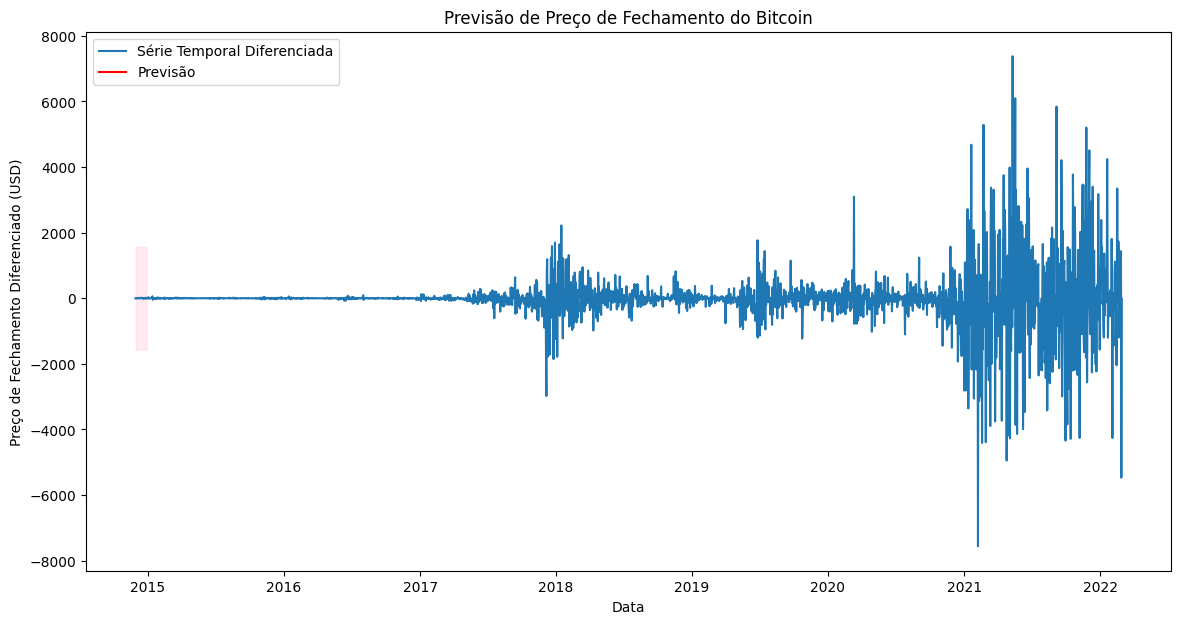

In [29]:
# Plotando previsão
plt.figure(figsize=(14, 7))
plt.plot(btc_series_diff['close'], label='Série Temporal Diferenciada')
plt.plot(forecast_df['Forecast'], label='Previsão', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower Bound'], forecast_df['Upper Bound'],
                 color='pink', alpha=0.3)
plt.title('Previsão de Preço de Fechamento do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Diferenciado (USD)')
plt.legend()
plt.show()

In [ ]:
# Dados MLP
X = []
y = []
window_size = 5
for i in range(len(btc_series_diff) - window_size):
    X.append(btc_series_diff['close'].values[i:i+window_size])
    y.append(btc_series_diff['close'].values[i+window_size])

X = pd.DataFrame(X)
y = pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# Normalização dos dados:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Treinando MLP
mlp_model = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000, random_state=42)
mlp_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)

In [ ]:
# Previsão com MLP
mlp_predictions = mlp_model.predict(X_test_scaled)
mlp_predictions_df = pd.DataFrame(mlp_predictions, index=y_test.index, columns=['Forecast'])

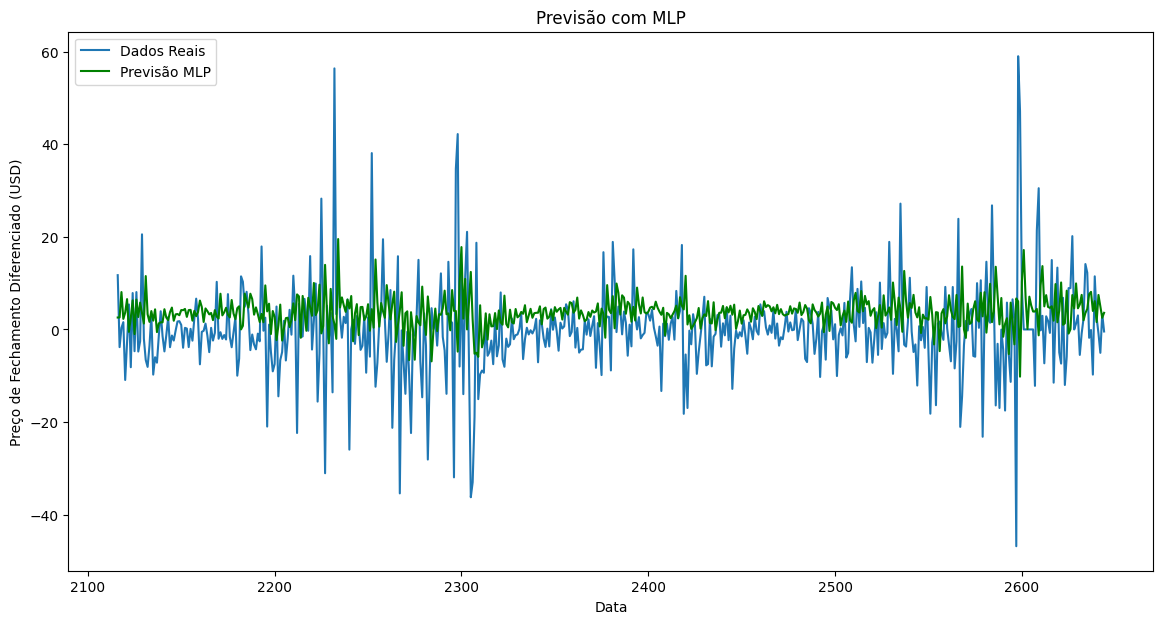

In [ ]:
# Plotando as previsões com MLP
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Dados Reais')
plt.plot(mlp_predictions_df['Forecast'], label='Previsão MLP', color='green')
plt.title('Previsão com MLP')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento Diferenciado (USD)')
plt.legend()
plt.show()

In [ ]:
# Cálculo WWAPE
def wmape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

arima_wmape = wmape(y_test, forecast_df['Forecast'][:len(y_test)])
mlp_wmape = wmape(y_test, mlp_predictions_df['Forecast'])

print(f'WMAPE do ARIMA: {arima_wmape:.2f}%')
print(f'WMAPE do MLP: {mlp_wmape:.2f}%')

WMAPE do ARIMA: 0.00%
WMAPE do MLP: 129.48%


In [26]:
# Tentar ajustar um modelo diferente, por exemplo, SARIMAX(1,1,1)
model_alternative = pm.auto_arima(btc_series['close'], seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, start_p=1, start_q=1, max_p=3, max_q=3, d=1, max_d=2)

# Fazer previsões
forecast_alternative, conf_int_alternative = model_alternative.predict(n_periods=30, return_conf_int=True)
print(forecast_alternative[:5])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=42942.948, Time=3.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=42944.205, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=42942.920, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=42942.925, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=42943.289, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=42936.097, Time=0.44 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=42935.047, Time=1.74 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=42934.501, Time=1.68 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=42937.113, Time=1.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=42924.177, Time=3.46 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=42924.458, Time=5.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=42924.521, Time=5.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=42924.137, Time=3.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=42934.358, Time=2.40 sec
 ARIMA(1,1,2)(0,0,0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
